In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import time
import sys

sys.path.append(os.path.abspath(".."))   # Add root path to sys.path
os.chdir("..")  # Change working directory to root path

from src.preprocessing import read_image, windy_preprocessing_pipeline
from tqdm import tqdm
from datetime import datetime

sys.path


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



['/opt/anaconda3/envs/cv_env/lib/python312.zip',
 '/opt/anaconda3/envs/cv_env/lib/python3.12',
 '/opt/anaconda3/envs/cv_env/lib/python3.12/lib-dynload',
 '',
 '/opt/anaconda3/envs/cv_env/lib/python3.12/site-packages',
 '/Users/tranquochieu/Documents/NCKH/Weather forecasting/Thunderstorm-Nowcasting-Geometry-Topology-Approach']

### Load data first

In [2]:
from src.preprocessing import read_numpy_grid, nexrad_numpy_preprocessing_pipeline
from tqdm import tqdm

data_name = "KARX"
SOURCE_PATH = f"data/numpy_grid/{data_name}"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.npy')
][:20]

img_shape = read_numpy_grid(img_paths[0]).shape       # get shape of the image

print(f"Image shape: {img_shape}")
print(f"-" * 20)

time_frames = []
dbz_maps = []

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    file_name = path.split("/")[-1].split(".")[0]
    # time_frames.append(datetime.strptime(file_name[:-4], '%Y%m%d-%H%M%S'))       # Get file name without extension
    time_frames.append(datetime.strptime(file_name[4:19], "%Y%m%d_%H%M%S"))       # Get file name without extension
    img = read_numpy_grid(path)
    dbz_maps.append(nexrad_numpy_preprocessing_pipeline(img))

FIRST_TIME_FRAME = time_frames[0]

print(f"Number of frames: {len(dbz_maps)}")

# replace nan values with 0
for i in range(len(dbz_maps)):
    dbz_maps[i] = np.nan_to_num(dbz_maps[i], nan=0.0)

(dbz_maps[0] > 0).sum()

Image shape: (901, 901)
--------------------


Processing images and detecting storms: 100%|██████████| 20/20 [00:00<00:00, 260.07it/s]

Number of frames: 20


np.int64(86692)

In [3]:
# file_name = "philippines_13.269_123.832"

# SOURCE_PATH = f"data/image_old/{file_name}"

# img_paths = [
#     os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
# ][:50]

# img_shape = read_image(img_paths[0]).shape       # get shape of the image
# print(f"Image shape: {img_shape}")
# print(f"-" * 20)

# time_frames = []
# dbz_maps = []       

# for path in tqdm(img_paths, desc="Processing images and detecting storms"):
#     time_frames.append(datetime.strptime(os.path.basename(path).split('/')[0][:-4], '%Y%m%d-%H%M%S'))       # Get file name without extension
#     img = read_image(path)
#     dbz_maps.append(windy_preprocessing_pipeline(img))

# print(f"Number of frames: {len(dbz_maps)}")

## Load model

In [4]:
from src.models import ISCITPrecipitationModel
from src.identification import HypothesisIdentifier
from src.cores.base import StormsMap

model = ISCITPrecipitationModel(identifier=HypothesisIdentifier())

storms_maps: list[StormsMap] = []
total_storms = 0
DENSITY = 0.1  # particle density

pbar = tqdm(zip(dbz_maps, time_frames), total=len(dbz_maps), desc="Detecting storms")
for idx, (dbz_map, time_frame) in enumerate(pbar):
    storms_map = model.identify_storms(
        dbz_map, time_frame, map_id=f"time_{idx}", threshold=35, filter_area=50, particle_density=DENSITY
    )
    total_storms += len(storms_map.storms)
    pbar.set_postfix({"Total storms detected": total_storms})

    storms_maps.append(storms_map)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/envs/cv_env/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/cv_env/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/envs/cv_env/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File 

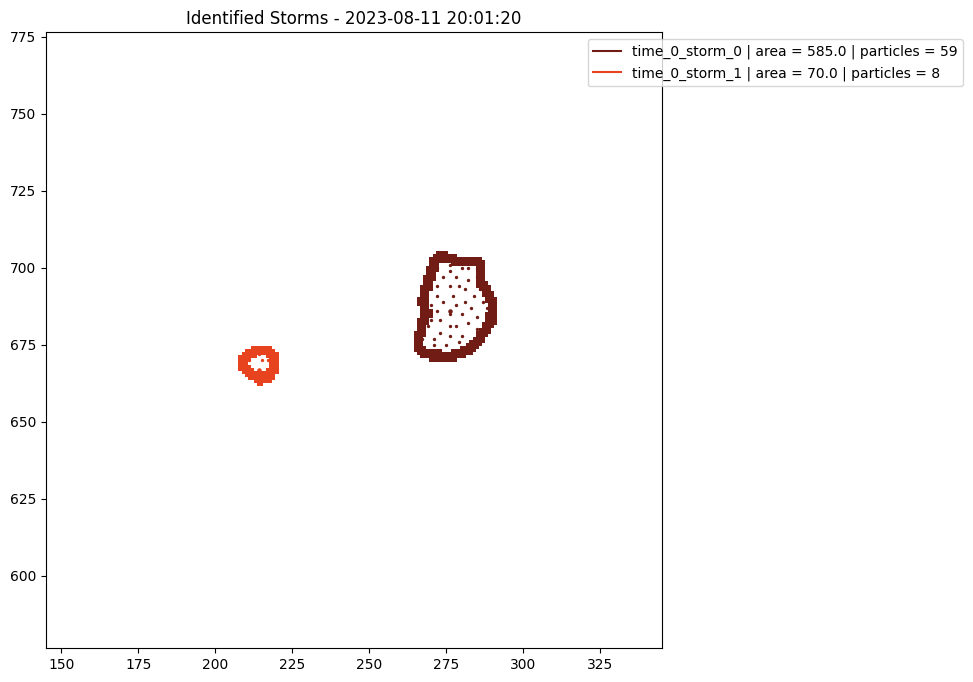

In [5]:
from src.preprocessing import convert_polygons_to_contours

# Visualize storms with contours on the first DBZ map
storms_map = storms_maps[0]
plt.figure(figsize=(10, 8))

img_shape = dbz_maps[0].shape
img_shape = (img_shape[0], img_shape[1], 3)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

# colors = spectral_colors(len(storms_map.storms))
displayed_centroid_lst = []

for storm in storms_map.storms:
    y_centroid, x_centroid = storm.centroid
    displayed_centroid_lst.append([y_centroid, x_centroid])
    color = storm.contour_color
    
    plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f} | particles = {storm.get_num_particles()}")
    plt.scatter(x_centroid, y_centroid, color=np.array(color)/255.0, s=5)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=2)  # Draw contour in red
    for particle in storm.particles:
        y_particle, x_particle = particle
        plt.scatter(x_particle, y_particle, color=np.array(color)/255.0, s=2)

displayed_centroid = np.mean(np.array(displayed_centroid_lst), axis=0)

plt.imshow(blank_image, cmap='grey')
plt.title(f"Identified Storms - {storms_map.time_frame}")
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0))
plt.xlim(displayed_centroid[1] - 100, displayed_centroid[1] + 100)
plt.ylim(displayed_centroid[0] - 100, displayed_centroid[0] + 100)

plt.show()

Storm time_0_storm_0 estimated movement vector: (np.float64(-1.687797147358355), np.float64(4.421553090262733))
Storm time_0_storm_1 estimated movement vector: (np.float64(-0.4588235293577855), np.float64(4.670588234744637))
Track  0. time_0_storm_0 -> time_1_storm_0
Lifespan: 2
	time_0_storm_0: 
	time_1_storm_0: (-41.22, 82.44)
--------------------------------------------------
Track  1. time_0_storm_1 -> time_1_storm_1
Lifespan: 2
	time_0_storm_1: 
	time_1_storm_1: (13.74, 68.70)
--------------------------------------------------
Track  2. time_1_storm_2
Lifespan: 1
	time_1_storm_2: 
--------------------------------------------------


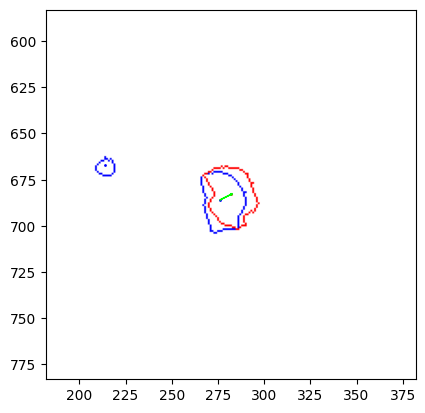

In [6]:
from src.cores.movement_estimate import TREC

prev_storm_map = storms_maps[0]
curr_storm_map = storms_maps[1]

trec = TREC(max_velocity=100.0)
grid_y, grid_x, vy, vx = trec.estimate_movement(prev_storm_map, curr_storm_map)

for idx, prev_storm in enumerate(prev_storm_map.storms):
    storm_vector = trec.average_storm_movement(
        prev_storm, prev_storm_map.dbz_map.shape[:2],
        grid_y, grid_x, vy, vx
    )
    print(f"Storm {prev_storm.id} estimated movement vector: {storm_vector}")

dt = (curr_storm_map.time_frame - prev_storm_map.time_frame).seconds / 3600   # scaled to hour

model = ISCITPrecipitationModel(identifier=HypothesisIdentifier())
model.processing_map(prev_storm_map)
model.processing_map(curr_storm_map)

model.tracker.print_tracks()

# plot the previous map
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

for storm in prev_storm_map.storms:
    y_centroid, x_centroid = storm.centroid
    
    plt.plot([], [], color=(0,0,1), label=f"{storm.id} | area = {storm.contour.area:.1f}")
    plt.scatter(x_centroid, y_centroid, color=(0,0,1), s=1)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, (0,0,255), thickness=1)  # Draw contour in blue

# plot the current storm
curr_idx = 0
y_centroid, x_centroid = curr_storm_map.storms[curr_idx].centroid
movement = curr_storm_map.storms[curr_idx].get_movement()
if movement is None:
    dy, dx = 0.0, 0.0
else:
    dy, dx = movement * dt

plt.plot([], [], color=(1,0,0), label=f"{curr_storm_map.storms[curr_idx].id} | area = {curr_storm_map.storms[curr_idx].contour.area:.1f}")
plt.scatter(x_centroid, y_centroid, color=(1,0,0), s=1)
cv2.drawContours(blank_image, convert_polygons_to_contours([curr_storm_map.storms[curr_idx].contour]), -1, (255,0,0), thickness=1)  # Draw contour in red

plt.arrow(
    x_centroid - dx, y_centroid - dy,
    dx, dy,
    color=(0, 1, 0), head_width=1, head_length=1
)

plt.imshow(blank_image, cmap='grey')
plt.xlim(x_centroid - 100, x_centroid + 100)
plt.ylim(y_centroid + 100, y_centroid - 100)

plt.show()

In [7]:
from src.cores.base import StormsMap
from src.cores.metrics import pod_score, far_score, csi_score

class PredictionBenchmarkModel:
    def __init__(self):
        self.pods = []
        self.fars = []
        self.csis = []
        self.actual = []
        self.predicted = []

    def evaluate_predict(self, actual_storms_map: StormsMap, predicted_storms_map: StormsMap):
        self.actual.append(actual_storms_map)
        self.predicted.append(predicted_storms_map)
        self.pods.append(pod_score(actual_storms_map, predicted_storms_map))
        self.fars.append(far_score(actual_storms_map, predicted_storms_map))
        self.csis.append(csi_score(actual_storms_map, predicted_storms_map))

# Create benchmark model
benchmark_model = PredictionBenchmarkModel()
PREDICT_FORWARD_STEPS = 3
SLOW_START_STEPS = 10

model = ISCITPrecipitationModel(identifier=HypothesisIdentifier(), max_velocity=200)  # max_velocity in pixels per hour
temp_storm_map = storms_maps

ours_model_evaluation = PredictionBenchmarkModel()
predicted_maps = []
lead_times = []

for i in range(SLOW_START_STEPS):
    model.processing_map(temp_storm_map[i])  # Warm-up phase

# model.tracker.print_tracks()

for curr_map, future_map in tqdm(list(zip(temp_storm_map[SLOW_START_STEPS:], temp_storm_map[PREDICT_FORWARD_STEPS + SLOW_START_STEPS:])), desc="Predicting precipitation maps"):
    # Predict map using current data
    dt_seconds = (future_map.time_frame - model.storms_maps[-1].time_frame).total_seconds()
    predicted_map = model.forecast(dt_seconds)
    ours_model_evaluation.evaluate_predict(future_map, predicted_map)
    lead_times.append(dt_seconds)

    # Update new map into knowledge
    model.processing_map(curr_map)  # Update model with the current map

print("Our model evaluation:")
print(f"\tAverage POD: {np.mean(ours_model_evaluation.pods):.4f}")
print(f"\tAverage FAR: {np.mean(ours_model_evaluation.fars):.4f}")
print(f"\tAverage CSI: {np.mean(ours_model_evaluation.csis):.4f}")

print(f"\tAverage lead time: {np.mean(lead_times) / 60:.2f} minutes")

Predicting precipitation maps: 100%|██████████| 7/7 [00:00<00:00, 47.13it/s]

Our model evaluation:
	Average POD: 0.6316
	Average FAR: 0.5398
	Average CSI: 0.3655
	Average lead time: 17.28 minutes


# Overall Analyzing on tracking process
In this tracking, I used both of the median duration and linearity error of tracking

Average object consistency score (area change rate): 0.2494


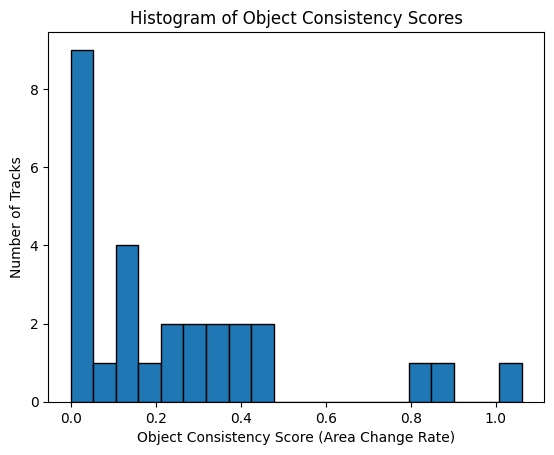

In [8]:
object_consistency_scores = []

for track in model.tracker.tracks:
    areas = [storm.contour.area for storm in track.storms.values()]
    area_changes = [abs(areas[i] - areas[i - 1]) / areas[i - 1] for i in range(1, len(areas)) if areas[i - 1] != 0]
    object_consistency_scores.append(np.mean(area_changes) if area_changes else 0)

object_consistency_scores = np.array(object_consistency_scores)

print(f"Average object consistency score (area change rate): {np.mean(object_consistency_scores):.4f}")

plt.hist(object_consistency_scores[object_consistency_scores < 2], bins=20, edgecolor='black')
plt.title("Histogram of Object Consistency Scores")
plt.xlabel("Object Consistency Score (Area Change Rate)")
plt.ylabel("Number of Tracks")
plt.show()

## B. Mean duration tracking

Median duration of tracking: 4.368098159509202 frames
Maximum duration of tracking: 16 frames
Mean duration of tracking: 4.37 frames


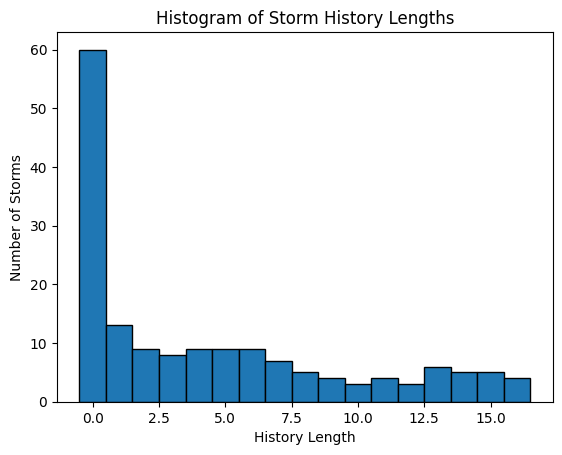

In [9]:
HISTORY_LENGTH_LST = []             # Retrieve history length of all storms

for storms_map in storms_maps:
    for storm in storms_map.storms:
        HISTORY_LENGTH_LST.append(len(storm.history_movements))   # Append history length of each storm

MEDIAN_DURATION = np.mean(HISTORY_LENGTH_LST)

print(f"Median duration of tracking: {MEDIAN_DURATION} frames")
print(f"Maximum duration of tracking: {max(HISTORY_LENGTH_LST)} frames")
print(f"Mean duration of tracking: {np.mean(HISTORY_LENGTH_LST):.2f} frames")

plt.hist(HISTORY_LENGTH_LST, bins=range(0, max(HISTORY_LENGTH_LST) + 2), align='left', edgecolor='black')
plt.title("Histogram of Storm History Lengths")
plt.xlabel("History Length")
plt.ylabel("Number of Storms")
plt.show()

## C. Linearity error tracking
Use linearity to track the different between linear fitting of previous history against the actual matched movement

In [10]:
from src.cores.metrics import linear_tracking_error
import matplotlib.pyplot as plt

# Accumulate linear errors for all storms
LINEAR_ERRORS_LST = []

for storms_map in tqdm(storms_maps, desc="Computing linear fitting errors for storms"):
    for storm in storms_map.storms:
        # If not enough history, skip
        if len(storm.history_movements) <= MEDIAN_DURATION:
            continue

        # Fit linear model
        error_distance = linear_tracking_error(storm.history_movements[:-1]) ** 2      # Final one used for evaluate the movement prediction
        LINEAR_ERRORS_LST.append(error_distance)

print(f"RMSE of linear fitting errors: {np.sqrt(np.mean(LINEAR_ERRORS_LST)):.4f}. Total length: {len(LINEAR_ERRORS_LST)}")

Computing linear fitting errors for storms: 100%|██████████| 20/20 [00:00<00:00, 1103.08it/s]

RMSE of linear fitting errors: 36.7868. Total length: 64


In [11]:
import colorsys

def spectral_colors(n: int) -> list[list[int]]:
    colors = []
    for i in range(n):
        # Hue ranges from 0.0 (red) to 0.83 (violet) approximately
        hue = i / max(1, n - 1) * 0.83  
        r, g, b = colorsys.hsv_to_rgb(hue, 1.0, 1.0)
        colors.append([int(r * 255), int(g * 255), int(b * 255)])
    return colors

Processing all storm maps for movement history visualization: 100%|██████████| 20/20 [00:00<00:00, 49.06it/s]


----  CURRENT MAP at time 2023-08-11 21:30:04  ----
Storm 0: Number of movement history records: 19
Storm 1: Number of movement history records: 19
Storm 2: Number of movement history records: 10
Storm 3: Number of movement history records: 11
Storm 4: Number of movement history records: 19
Storm 5: Number of movement history records: 10
Storm 6: Number of movement history records: 9
Storm 7: Number of movement history records: 4
Storm 8: Number of movement history records: 4
Storm 9: Number of movement history records: 11
Storm 10: Number of movement history records: 11
Storm 11: Number of movement history records: 19
Storm 12: Number of movement history records: 0
Storm 13: Number of movement history records: 0


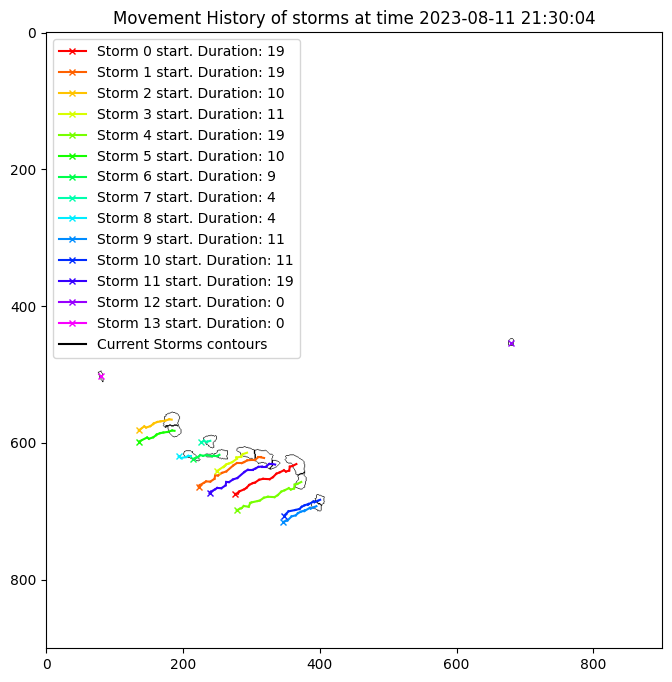

In [12]:
from src.preprocessing import convert_polygons_to_contours

num_maps = len(storms_maps)

model = ISCITPrecipitationModel(identifier=HypothesisIdentifier())  # max_velocity in pixels per hour

for i in tqdm(range(num_maps), desc="Processing all storm maps for movement history visualization"):
    model.processing_map(storms_maps[i])  # Warm-up phase
    # if i == 2:
    #     break

plt.figure(figsize=(8, 8))
blank_img = np.ones(shape=(img_shape[0], img_shape[1], 3), dtype=np.uint8) * 255

current_map = model.storms_maps[-1]
print(f"----  CURRENT MAP at time {current_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')}  ----")

colors = spectral_colors(len(current_map.storms))

for idx, storm in enumerate(current_map.storms):
    print(f"Storm {idx}: Number of movement history records: {len(storm.history_movements)}")
    current_frame = current_map.time_frame

    color = np.array(colors[idx]) / 255.0
    end_point = (storm.contour.centroid.x, storm.contour.centroid.y)

    # backtrack the movement history
    for move_idx, movement in enumerate(storm.history_movements):
        prev_frame = model.storms_maps[-(move_idx + 2)].time_frame
        dt = (current_frame - prev_frame).total_seconds() / 3600
        current_frame = prev_frame

        dy, dx = movement[0] * dt, movement[1] * dt

        start = end_point[0] - dx, end_point[1] - dy
        plt.plot([start[0], end_point[0]], [start[1], end_point[1]], color=color)
        end_point = start
    
    plt.plot(end_point[0], end_point[1], marker='x', color=color, markersize=5, label=f'Storm {idx} start. Duration: {len(storm.history_movements)}')

contours = convert_polygons_to_contours([storm.contour for storm in current_map.storms])
cv2.drawContours(blank_img, contours, -1, (0, 0, 0), 1)
plt.plot([], [], color='black', label='Current Storms contours')
plt.title(f"Movement History of storms at time {current_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')}")

plt.imshow(blank_img)
plt.legend()

plt.show()